# **INSTRUCTION**

E-commerce is evolving day by day. The excutives should pay attention to reviews from the customers. Theses reviews reflect the customers' satisfactions. This report will classify over 11000 reviews from Tiki into 2 categoories: positive and negative. 

# **IMPORT LIBRARIES**

In [1]:
# !pip install wordcloud
# !pip install pyvi
# !pip install -U gensim

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import multiprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
import tensorflow as tf
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec, Phrases
from pyvi import ViPosTagger, ViTokenizer #Tokenize tiếng Việt
import wordcloud
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.layers import Dropout, Activation, TimeDistributed, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D, LSTM, Bidirectional, Activation, GRU

# **EXPLORING THE DATA**

In [2]:
xl = pd.ExcelFile('data.xlsx')
for name in xl.sheet_names:
    data = xl.parse(name)

In [3]:
data.head(10)

,Rating,Content
0,5,1234570000000000120924793754905402008253644144...
1,5,"""Cuộc hành trình ngàn dặm nào cũng phải bắt đầ..."
2,5,*Thật sự rất đáng tiền khi mua cuốn sách này đ...
3,5,","
4,5,.
5,5,.
6,5,.!-?:’ khá đẹp và dễ dùng
7,5,.................................................
8,5,"....Bút dùng tốt, màu sắc đẹp, đáng giá,nên mu..."
9,5,: D


In [4]:
data.shape

(11269, 2)

The data set has 11600 records and 3 features.

In [5]:
data.dtypes

Rating      int64
Content    object
dtype: object

The data have 3 features:
- "Rating" contains integer values which show the level of goods and service ratings. 
- "Title" haves object values show general reviews.
- "Content" haves object values show detailed reviews about goods as well as services.

In [6]:
display(data.isnull().sum()/len(data)) 

Rating     0.0
Content    0.0
dtype: float64

Checking NULL values, we can see that there are about 3% reviews that not have *Content*. We convert NaN values to string values.

In [7]:
for i in range(len(data)):
    data.Content[i] = str(data.Content[i])

<ipython-input-7-b350449444a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Content[i] = str(data.Content[i])


In [8]:
display(data.isnull().sum()/len(data)) 

Rating     0.0
Content    0.0
dtype: float64

There are no more NULL values.

In [9]:
fig = px.histogram(data, x="Rating")
fig.show()

From the plot, we can see that there are so many positive ratings (4 or 5 stars). There are very few reviews rated below 4 stars.

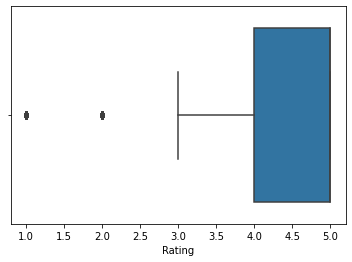

In [11]:
ax = sns.boxplot(x=data['Rating'])
plt.show()

# **PROCESSING DATA**

Before using model to classify reviews, we need to process the data. Firstly, we will classify "Rating" into two categories, which is greater than 3 will be rated at positive and vice versa.

In [10]:
data["Rating"] = [1 if each > 3 else 0 for each in data["Rating"]]
data.head(10)

,Rating,Content
0,1,1234570000000000120924793754905402008253644144...
1,1,"""Cuộc hành trình ngàn dặm nào cũng phải bắt đầ..."
2,1,*Thật sự rất đáng tiền khi mua cuốn sách này đ...
3,1,","
4,1,.
5,1,.
6,1,.!-?:’ khá đẹp và dễ dùng
7,1,.................................................
8,1,"....Bút dùng tốt, màu sắc đẹp, đáng giá,nên mu..."
9,1,: D


In [11]:
fig = px.histogram(data, x="Rating")
fig.show()

In [12]:
data['Rating'].value_counts() / len(data)

1    0.849232
0    0.150768
Name: Rating, dtype: float64

Nhận xét: có những từ không đúng chính tả, dấu thanh điệu không tương thích ví dụ "hòa" và "hoà", các emoji mang sắc thái tích cực và tiêu cực, teencode,... Trước hết cần đồng nhất những cái này 

Change strings to lowercase

In [13]:
data['Content'] = data['Content'].str.lower()
data.head(10)

,Rating,Content
0,1,1234570000000000120924793754905402008253644144...
1,1,"""cuộc hành trình ngàn dặm nào cũng phải bắt đầ..."
2,1,*thật sự rất đáng tiền khi mua cuốn sách này đ...
3,1,","
4,1,.
5,1,.
6,1,.!-?:’ khá đẹp và dễ dùng
7,1,.................................................
8,1,"....bút dùng tốt, màu sắc đẹp, đáng giá,nên mu..."
9,1,: d


In [14]:
for i in range(len(data)):
    data['Content'][i] =  data['Content'][i].replace(':3','')
    data['Content'][i] =  data['Content'][i].replace(':v','')
    data['Content'][i] =  data['Content'][i].replace(':o','')
    data['Content'][i] =  data['Content'][i].replace('"','')

<ipython-input-14-395b992a9395>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-395b992a9395>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-395b992a9395>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-395b992a9395>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [15]:
data['Content'] = data['Content'].str.replace('[{}]'.format(",#.:@;()$`~/-\^<>+=!"), '')
data

<ipython-input-15-3ae06f39e333>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



,Rating,Content
0,1,
1,1,cuộc hành trình ngàn dặm nào cũng phải bắt đầu...
2,1,*thật sự rất đáng tiền khi mua cuốn sách này đ...
3,1,
4,1,
...,...,...
11264,0,yêu cầu shop xác nhận đơn hàng dùm lâu quá rồi
11265,0,yêu cầu tiki dán tem hàng dể vỡ mua bia về làm...
11266,0,yêu cầu tiki làm việc với bên vận chuyển giao ...
11267,0,yêu câu tiki xác nhận có đúng chính xác là ino...


In [16]:
for i in range(len(data)):
    data['Content'][i] =  ViPosTagger.postagging(ViTokenizer.tokenize(data['Content'][i]))[0]

<ipython-input-16-7c8f8e320705>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
print(data['Content'][3830])
print(data['Content'][5722])
print(data['Content'][4578])
print(data['Content'][8388])

['máy', 'xài', 'tốt', 'đáng', 'đồng_tiền', 'bát', 'gạo']
['sản_phẩm_chất_lượng']
['nhỏ', 'gọn', 'dễ', 'dùng']
['hài_lòng']


In [18]:
dictionary = {
#     'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
#     'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
#     'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
#     'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
#     'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
    # EMOJI
    "👹": 'negative', "👻": 'positive', "💃": 'positive','🤙': 'positive', '👍': 'positive',
    "💄": 'positive', "💎": 'positive', "💩": 'positive',"😕": 'negative', "😱": 'negative', "😸": 'positive',
    "😾": 'negative', "🚫": 'negative',  "🤬": 'negative',"🧚": 'positive', "🧡": 'positive','🐶': 'positive',
    '👎': 'negative', '😣': 'negative','✨': 'positive', '❣': 'positive','☀': 'positive',
    '♥': 'positive', '🤩': 'positive', 'like': 'positive', '💌': 'positive',
    '🤣': 'positive', '🖤': 'positive', '🤤': 'positive', '😢': 'negative',
    '❤': 'positive', '😍': 'positive', '😘': 'positive', '😪': 'negative', '😊': 'positive',
    '😁': 'positive', '💖': 'positive', '😟': 'negative', '😭': 'negative',
    '💯': 'positive', '💗': 'positive', '♡': 'positive', '💜': 'positive', '🤗': 'positive',
    '😨': 'negative', '☺': 'positive', '💋': 'positive', '👌': 'positive',
    '😖': 'negative', '😀': 'positive', '😡': 'negative', 
    '😠': 'negative', '😒': 'negative', '🙂': 'positive', '😏': 'negative', '😝': 'positive', 
    '😙': 'positive', '😤': 'negative', '😎': 'positive', '😆': 'positive', '💚': 'positive',
    '✌': 'positive', '💕': 'positive', '😞': 'negative', '😓': 'negative', '️🆗️': 'positive',
    '😉': 'positive', '😂': 'positive', ':v': 'positive', '😋': 'positive',
    '💓': 'positive', '😐': 'negative', ':3': 'positive', '😫': 'negative', '😥': 'negative',
    '😃': 'positive', '😬': 'negative', '😌': 'negative', '💛': 'positive', '🤝': 'positive', '🎈': 'positive',
    '😗': 'positive', '🤔': 'negative', '😑': 'negative', '🔥': 'negative', '🙏': 'negative',
    '🆗': 'positive', '😻': 'positive', '💙': 'positive', '💟': 'positive',
    '😚': 'positive', '❌': 'negative', '👏': 'positive',
    '🌝': 'positive',  '🌷': 'positive', '🌸': 'positive', '🌺': ' positive ',
    '🌼': 'positive', '🍓': 'positive', '🐅': 'positive', '🐾': 'positive', '👉': 'positive',
    '💐': 'positive', '💞': 'positive', '💥': 'positive', '💪': 'positive', '🎉': 'positive',
    '💰': 'positive',  '😇': 'positive', '😛': 'positive', '😜': 'positive', '😄': 'positive',
    '🙃': 'positive', '🤑': 'positive', '🤪': 'positive','☹': 'negative',  '💀': 'negative',
    '😔': 'positive', '😧': 'negative', '😩': 'negative', '😰': 'negative', '😳': 'negative',
    '😵': 'positive', '😶': 'negative', '🙁': 'negative',
    # 
    u'ô_kêi': 'ok', 'okie': 'ok', u'ô_kê': 'ok', 'okey': 'ok', u'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 
    'okay': 'ok', 'tks': u'cám_ơn', 'thks': u'cám_ơn', 'thanks': u'cám_ơn', 'ths': u'cám_ơn', 'thank': u'cám_ơn', 
    u'cảm_ơn': u'cám_ơn', '⭐': 'star', '*': 'star','🌟': 'star', 'kg': u'không', 'not': u'không', 
    'k': u'không', 'kh': u'không', u'kô': u'không', 'hok': u'không', 'kp': u'không_phải', 'ko': u'không', 
    'khong': u'không', 'he_he': 'positive','hehe': 'positive', 'hihi': 'positive', 'haha': 'positive', 
    'hjhj': 'positive', 'lol': 'negative','cc': 'negative', 'cute': u'dễ_thương', 'huhu': 'negative', 'vs': u'với',
    'wa': u'quá', 'wá': u'quá', 'j': u'gì', 'sz': u'kích_cỡ', ' size': u'kích_cỡ', 'đx': u'được', 'dk': u'được',
    'dc': u'được', 'đk': u'được', 'đc': u'được','authentic': u'chính_hãng','aut': u'chính_hãng', 'auth': u'chính_hãng', 
    'thick': u'dày', 'store': u'cửa_hàng', 'shop': u'cửa_hàng', 'sp': u'sản_phẩm', 'gud': u'tốt','weldone':'tốt', 
    'good': u'tốt', 'very': u'rất', u'gút': u'tốt', 'gut': u'tốt', u'tot': u'tốt', 'nice': 'tốt', 'perfect': u'hoàn_hảo', 
    'bt': u'bình_thường', 'time': u'thời_gian', u'qá': u'quá', 'ship': u'giao_hàng', 'm': u'mình', 'mik': u'mình', 
    'product': u'sản_phẩm', 'quality': u'chất_lượng','chat': u'chất', 'excelent': u'hoàn_hảo', 'bad': u'tệ',
    'fresh': u'tươi', 'sad': u'buồn', 'date': u'hạn_sử_dụng', 'hsd': u'hạn_sử_dụng','quickly': u'nhanh', 
    'quick': u'nhanh', 'fast': u'nhanh', 'delivery': u'giao_hàng', u'síp': u'giao_hàng', 'shipper': u'người_giao_hàng', 
    'beautiful': u'đẹp', 'tl': u'trả_lời', 'r': u'rồi', 'shopE': u'cửa_hàng', 'order': u'đặt_hàng', 
    u'chất_lg': u'chất_lượng', 'sd': u'sử_dụng', 'dt': u'điện_thoại', 'nt': u'nhắn_tin', u'sài': u'xài', 
    'bjo': u'bao_giờ', 'thik': u'thích', 'sop': u'cửa_hàng', 'fb': 'facebook','dep': u'đẹp', 'xau': u'xấu', 
    'delicious': u'ngon', u'hàg': u'hàng', u'qủa': u'quả', 'iu': u'yêu', 'fake': u'giả_mạo', 'trl': u'trả_lời', 
    'por': u'tệ', 'poor': u'tệ', 'ib': u'nhắn_tin', 'rep': u'trả_lời', u'fback': 'feedback', 'fedback': 'feedback',
    'mn': u'mọi_người', 'cx': u'cũng', '&': u'và'
}

In [19]:
for i in range(len(data)):
    rev_subs = { k:v for k,v in dictionary.items()}
    data['Content'][i] = [rev_subs.get(item,item)  for item in data['Content'][i]]

<ipython-input-19-ed5a1e6fd710>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
print(data['Content'][3974])
print(data['Content'][1333])
print(data['Content'][5124])
print(data['Content'][4666])

['mình', 'đặt', 'mua', 'thùng', 'bia', 'và', 'nhận', 'được', 'phần', 'quà', 'tuy_nhiên', 'cái', 'ly', 'rất', 'đẹp', 'trong', 'hộp', 'quà', 'bị', 'vỡ', 'mong', 'tiki', 'lưu_ý', 'đóng_gói', 'cẩn_thận', 'để', 'việc', 'vận_chuyển', 'hàng', 'đến', 'tay', 'khách_hàng', 'không', 'phát_sinh', 'những', 'vấn_đề', 'tương_tư']
['đẹp', 'có', 'nhiều', 'cấp', 'nhiệt_độ', 'đun', 'để', 'chọn', 'và', 'màu', 'khác', 'nhau', 'chỉ', 'sợ', 'bị', 'bể', 'vỡ', 'thôi', 'giá', 'hơi', 'cao', 'tí', 'so', 'với', 'sản_phẩm']
['rất', 'hài_lòng', 'bộ', 'không', 'móp', 'hay', 'bị', 'gì', 'hết', 'vẫn', 'còn', 'nguyên_vẹn', 'hàng', 'rất', 'tốt']
['nội_dung', 'sách', 'viết', 'hay', 'và', 'dễ', 'hiểu', 'rất', 'hài_lòng', 'về', 'sản_phẩm']


In [21]:
data1 = data

In [22]:
for i in range(len(data)):
    data['Content'][i] = ' '.join([str(elem) for elem in data['Content'][i]])

<ipython-input-22-45561f42f631>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
print(data['Content'][3974])
print(data['Content'][1333])
print(data['Content'][11162])
print(data['Content'][4666])

mình đặt mua thùng bia và nhận được phần quà tuy_nhiên cái ly rất đẹp trong hộp quà bị vỡ mong tiki lưu_ý đóng_gói cẩn_thận để việc vận_chuyển hàng đến tay khách_hàng không phát_sinh những vấn_đề tương_tư
đẹp có nhiều cấp nhiệt_độ đun để chọn và màu khác nhau chỉ sợ bị bể vỡ thôi giá hơi cao tí so với sản_phẩm
thẻ_nhớ mua lần nào về lắp cam cũng lỗi liên_hệ cửa_hàng không được
nội_dung sách viết hay và dễ hiểu rất hài_lòng về sản_phẩm


In [25]:
#Hung: bỏ từ khong
stop_words = np.array([u'đã', u'sẽ', u'nhưng', u'mỗi', u'chỉ', u'vì', u'bởi', u'bởi_vì', u'của', u'khi', 
                       u'ai', u'thì', u'là', u'có_lẽ', u'có_vẻ', u'nhưng_mà', u'tuy_nhiên', u'với', u'và', u'bây_giờ', 
                       u'có', u'vài', u'ít', u'lần_nữa', u'một_lần_nữa', u'nào', u'duy_nhất', u'cho', 
                       u'đây', u'đó', u'kia', u'kìa', u'này', u'thôi', u'cho_đến_khi', u'nên', u'hoặc', u'mà', 
                       u'chẳng', u'mình', u'tôi', u'nữa', u'tại', u'kia', u'rằng', u'bây_giờ', u'được', u'bị', 
                       u'sau_đó', u'trong_lúc', u'trong_khi', u'cái_gì', u'đấy', u'đó', u'về', u'còn', u'hầu_hết',
                       u'cũng', u'mặc_dù', u'luôn', u'một', u'bất_kỳ', u'bất_kì', u'nữa', u'ở', u'trở_nên', u'có_thể',
                       u'có_lẽ', u'hơn_nữa', u'thậm_chí', u'vì_vậy', u'rất', u'quá', u'hơi_hơi', u'tại_sao', u'lắm',
                       u'thấy', u'nhiều', u'thực_sự', u'lâu_lâu', u'đâu', u'để'])
stop_words

array(['đã', 'sẽ', 'nhưng', 'mỗi', 'chỉ', 'vì', 'bởi', 'bởi_vì', 'của',
       'khi', 'ai', 'thì', 'là', 'có_lẽ', 'có_vẻ', 'nhưng_mà',
       'tuy_nhiên', 'với', 'và', 'bây_giờ', 'có', 'vài', 'ít', 'lần_nữa',
       'một_lần_nữa', 'nào', 'duy_nhất', 'cho', 'đây', 'đó', 'kia', 'kìa',
       'này', 'thôi', 'cho_đến_khi', 'nên', 'hoặc', 'mà', 'chẳng', 'mình',
       'tôi', 'nữa', 'tại', 'kia', 'rằng', 'bây_giờ', 'được', 'bị',
       'sau_đó', 'trong_lúc', 'trong_khi', 'cái_gì', 'đấy', 'đó', 'về',
       'còn', 'hầu_hết', 'cũng', 'mặc_dù', 'luôn', 'một', 'bất_kỳ',
       'bất_kì', 'nữa', 'ở', 'trở_nên', 'có_thể', 'có_lẽ', 'hơn_nữa',
       'thậm_chí', 'vì_vậy', 'rất', 'quá', 'hơi_hơi', 'tại_sao', 'lắm',
       'thấy', 'nhiều', 'thực_sự', 'lâu_lâu', 'đâu', 'để'], dtype='<U11')

In [26]:
sentences = []
for comment in data['Content']:
    sent = []
    for word in comment.split(" ") :
        if (word not in stop_words) :
            if ("_" in word) or (word.isalpha() == True):
                sent.append(word)
    sentences.append(" ".join(sent))

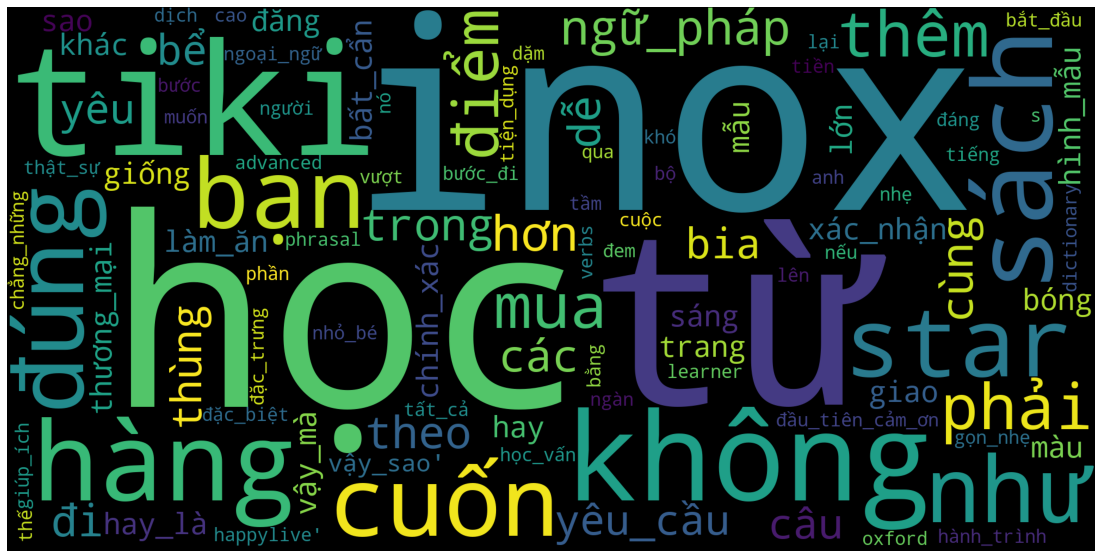

In [27]:
plt.figure(figsize=(20,10))
cloud = np.array(sentences).flatten()
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [28]:
plt.figure(figsize=(16,5))
counter=Counter(data['Content'])
most=counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    x.append(word)
    y.append(count)

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:>

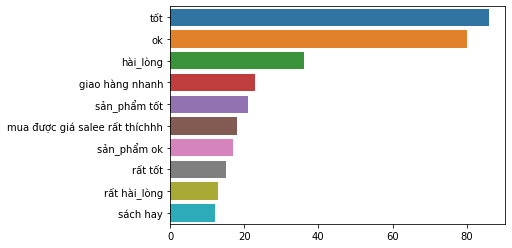

In [29]:
sns.barplot(x=y,y=x)

## Positive

In [30]:
data_pos = data[data['Rating'] == 1]
len(data_pos)

9570

In [31]:
sentences = []
for comment in data_pos['Content']:
    sent = []
    for word in comment.split(" ") :
        if (word not in stop_words) :
            if ("_" in word) or (word.isalpha() == True):
                sent.append(word)
    sentences.append(" ".join(sent))

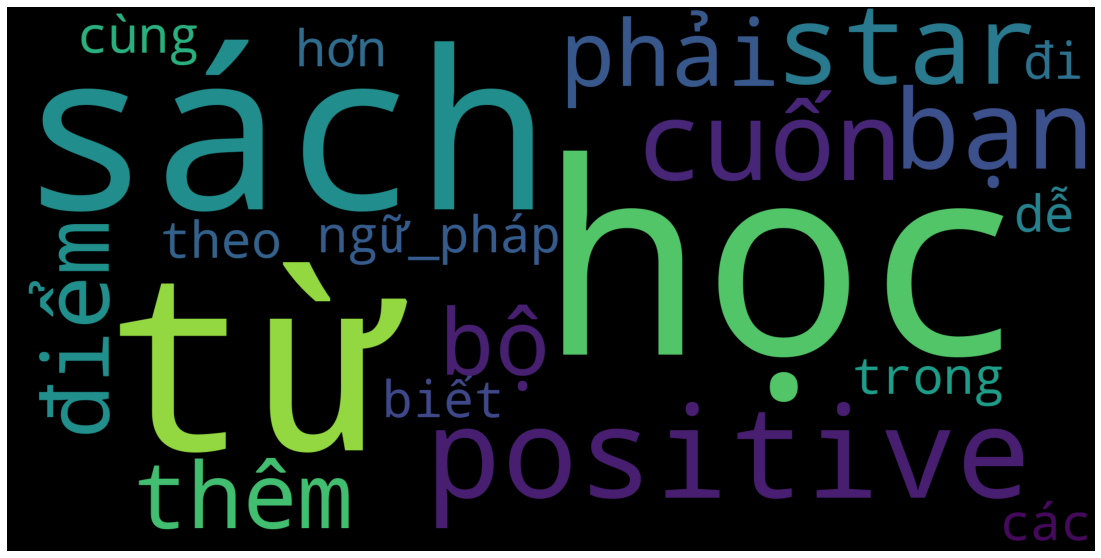

In [32]:
plt.figure(figsize=(20,10))
cloud = np.array(sentences).flatten()
word_cloud = wordcloud.WordCloud(max_words=20,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [33]:
counter=Counter(data_pos['Content'])
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

<AxesSubplot:>

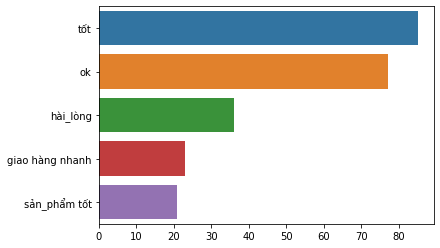

In [34]:
sns.barplot(x=y,y=x)

## Negative

In [35]:
data_neg = data[data['Rating'] == 0]
len(data_neg)

1699

In [36]:
sentences = []
for comment in data_neg['Content']:
    sent = []
    for word in comment.split(" ") :
        if (word not in stop_words) :
            if ("_" in word) or (word.isalpha() == True):
                sent.append(word)
    sentences.append(" ".join(sent))

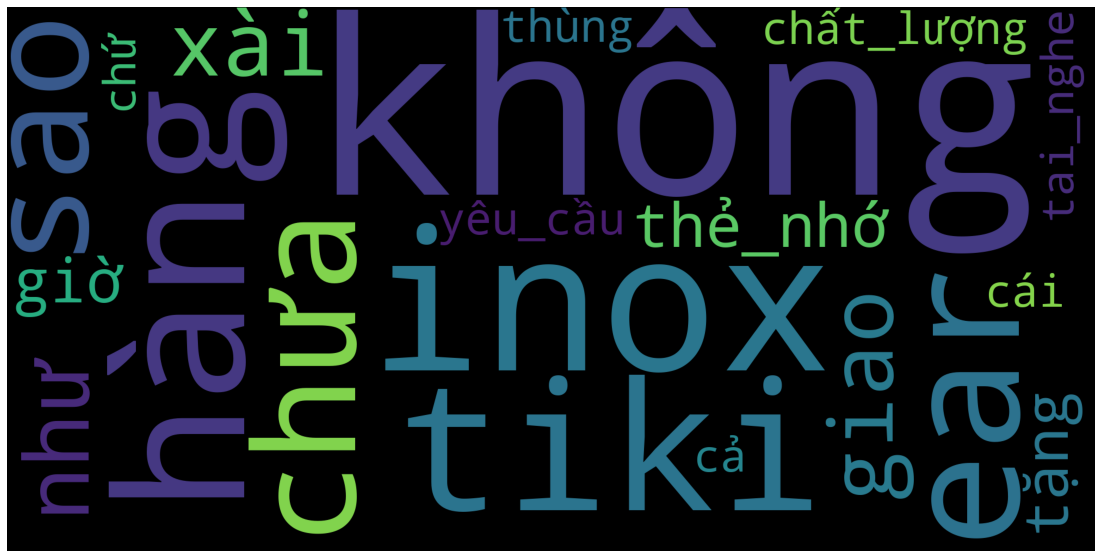

In [37]:
plt.figure(figsize=(20,10))
cloud = np.array(sentences).flatten()
word_cloud = wordcloud.WordCloud(max_words=20,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

In [38]:
counter=Counter(data_neg['Content'])
most=counter.most_common()
x=[]
y=[]
for word,count in most[:5]:
    x.append(word)
    y.append(count)

In [39]:
most[:5]

[('bình_thường', 3),
 ('ok', 3),
 ('giao hàng quá chậm', 2),
 ('giao hàng quá lâu', 2),
 ('màu_sắc bình đun nước đẹp giống hình tuy_nhiên chất_liệu không ổn lắm đế nấu bằng nhựa trắng vỏ bình bên ngoài nhựa màu bên trong kim_loại tất_cả đều mỏng cầm rất nhẹ_tay cảm_giác giống đang cầm_đồ_chơi chứ không phải sản_phẩm gia_dụng đợt này tiki gói hàng rất sơ_sài không đẹp không gọn như thời_gian trước nói_chung mình có chút thất_vọng vì đây là hàng do tiki trading phân_phối',
  2)]

<AxesSubplot:>

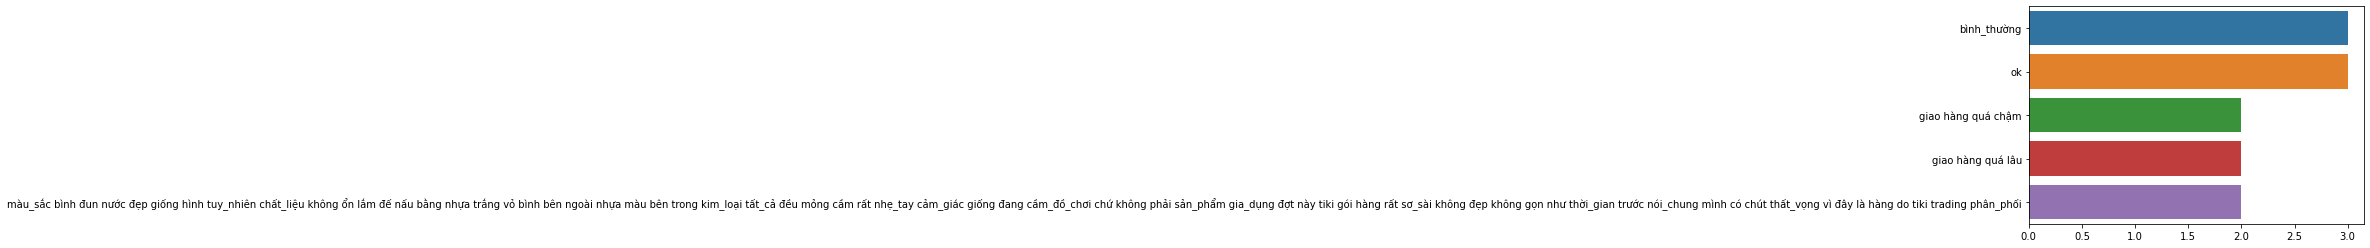

In [40]:
sns.barplot(x=y,y=x)

In [41]:
def remove_stopwords(input_text):
    whitelist = ["không", "không_thể", "chẳng"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stop_words or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
data.Content = data.Content.apply(remove_stopwords)
data.head()

,Rating,Content
0,1,
1,1,cuộc hành_trình ngàn dặm phải bắt_đầu bằng bướ...
2,1,star thật_sự đáng tiền mua cuốn sách học thêm ...
3,1,
4,1,


In [42]:
data.loc[data['Content'].apply(lambda x : len(x) == 0),'Content'] = np.nan
data.dropna()['Rating'].value_counts()

1    9546
0    1698
Name: Rating, dtype: int64

In [43]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

# 5. CLASSIFICATION 

## 5.1 Word2vec

In [44]:
input_size = 1000
max_features = 400

In [45]:
def read_questions(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))
    
documents = []
for index, row in data.iterrows():
    documents.append(read_questions(row, "Content"))

In [46]:
documents[0]

['cuộc',
 'hành_trình',
 'ngàn',
 'dặm',
 'phải',
 'bắt_đầu',
 'bằng',
 'bước_đi',
 'nhỏ_bé',
 'đầu_tiên_cảm_ơn',
 'bộ',
 'sách',
 'dịch',
 'happylive']

In [47]:
w2v_model = Word2Vec(vector_size=300, window=10, min_count=2, sg=1, workers=10)

In [48]:
w2v_model.build_vocab(documents, progress_per=10000)

In [49]:
w2v_model.train(corpus_iterable=documents, total_examples=len(documents), epochs=8)

(1012121, 1316360)

In [50]:
w2v_model.wv.most_similar("điện_thoại")

[('iphone', 0.7793577313423157),
 ('camera', 0.7507793307304382),
 ('samsung', 0.7498090863227844),
 ('hành_trình', 0.7448731064796448),
 ('định_dạng', 0.7351607084274292),
 ('mượt_mà', 0.7321651577949524),
 ('trãi', 0.7307790517807007),
 ('cùi', 0.7273775935173035),
 ('thoại', 0.7263613343238831),
 ('readwrite', 0.725723385810852)]

## 5.2 Sentiment Analysis

In [51]:
bow_vectorizer = CountVectorizer(max_features = max_features)
bow = bow_vectorizer.fit_transform(data['Content'])
bow.shape

(11244, 400)

In [52]:
train_bow = bow[:11600,:]

In [53]:
tokenized_review = data['Content'].apply(lambda x: x.split())

In [54]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
wordvec_arrays = np.zeros((len(data), 300)) 
for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_review[i], 300)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(11244, 300)

In [55]:
train_w2v = wordvec_df.iloc[:11600,:]
test_w2v = wordvec_df.iloc[11600:,:]

In [56]:
train_w2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.137071,0.087042,-0.004561,0.112710,0.034025,-0.007320,0.063200,0.179807,-0.015399,0.041472,...,-0.098180,0.130274,0.101652,-0.046673,0.147216,0.079686,-0.023110,-0.129413,-0.005605,0.009112
1,0.140682,0.009767,0.018990,0.105322,0.044345,-0.070417,0.045979,0.223946,-0.042374,0.145247,...,-0.079224,0.148095,0.097995,-0.122297,0.119563,0.095411,-0.018646,-0.116535,0.029951,-0.015341
2,0.068406,0.074010,-0.083788,0.029783,0.028737,-0.185997,0.064892,0.231338,-0.126459,0.029821,...,0.054298,-0.005946,0.054741,-0.154419,0.148034,0.141956,-0.091079,0.036904,0.038452,-0.166867
3,0.148257,0.026920,-0.024794,0.051074,-0.028506,-0.073694,-0.037902,0.287771,-0.118766,-0.054662,...,0.014618,0.157759,0.130706,0.100161,0.065278,0.133637,-0.128946,0.037419,0.087308,-0.126010
4,0.264474,0.011788,0.017328,0.018236,0.141143,-0.201780,0.020854,0.311890,-0.057975,0.080771,...,0.006196,0.176525,0.078152,-0.004975,0.051012,0.278554,0.043964,-0.014672,0.134438,-0.094118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11239,0.206032,0.042219,0.171576,0.159767,0.093809,-0.136441,0.041967,0.359725,-0.278926,0.059743,...,-0.057867,0.173215,0.106805,0.029399,0.143434,0.187090,-0.004152,-0.069785,0.220767,-0.145900
11240,0.146131,0.018453,0.117436,0.076923,0.038023,-0.145030,0.053373,0.325578,-0.124454,-0.058252,...,-0.026128,0.077946,0.091758,0.050648,0.101456,0.184900,-0.041149,-0.027459,0.124547,-0.069723
11241,0.135280,-0.007564,0.087291,0.081969,0.041002,-0.130463,0.063215,0.356788,-0.107806,-0.018317,...,-0.046957,0.073145,0.050216,0.034098,0.124323,0.181321,-0.040778,-0.068034,0.149423,-0.055779
11242,0.166242,0.061861,0.058010,0.139784,0.051468,-0.125267,0.069103,0.314565,-0.193662,-0.009026,...,-0.000633,0.141340,0.100732,0.029513,0.089934,0.118216,-0.026046,-0.003416,0.057378,-0.058620


In [57]:
test_w2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299


In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(train_bow, np.array(data['Rating']), random_state = 25, test_size = 0.3, stratify=np.array(data['Rating']))

# SMOTE: upsampling minority class

In [59]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [60]:
import matplotlib.pyplot as plt

In [61]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
counter = Counter(Y_train)
print(counter)

Counter({1: 6682, 0: 1188})


In [62]:
over = SVMSMOTE(sampling_strategy=0.3)
# under = RandomUnderSampler(sampling_strategy=0.6)
# steps = [('o', over), ('u', under)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

In [63]:
X, Y = pipeline.fit_resample(X_train, Y_train)

In [64]:
Counter(Y)

Counter({0: 2004, 1: 6682})

In [65]:
Counter(Y)[0] / (Counter(Y)[0] + Counter(Y)[1])

0.23071609486530048

In [66]:
counter = Counter(Y_test)
print(counter)

Counter({1: 2864, 0: 510})


### Logistic Regression

In [67]:
LOR = LogisticRegression(solver='lbfgs',max_iter = 150) 

In [68]:
LOR.fit(X, Y) 

LOR.score(X_test, Y_test)

0.8838174273858921

In [69]:
y_pred = LOR.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 293,  217],
       [ 175, 2689]])

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



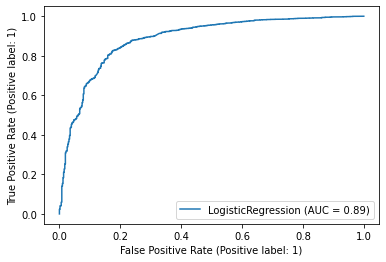

In [70]:
LOR_disp = plot_roc_curve(LOR, X_test, Y_test)
plt.show()

In [82]:


yhat = LOR.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.802978, G-Mean=0.826


In [71]:
import pickle
pickle.dump(LOR, open('logistic.sav', 'wb'))

### Random Forest

In [72]:
RF = RandomForestClassifier(max_depth = 50, n_jobs = -1, random_state = 18, n_estimators = 140)
RF.fit(X, Y) 
RF.score(X_test, Y_test)

0.8876704208654416

In [73]:
y_pred = RF.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 258,  252],
       [ 127, 2737]])

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



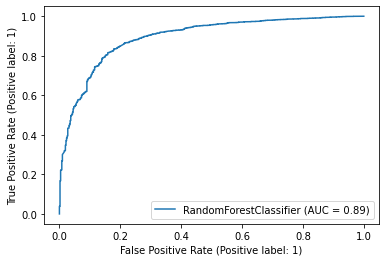

In [74]:
RF_disp = plot_roc_curve(RF, X_test, Y_test)
plt.show()

In [83]:
yhat = RF.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.731134, G-Mean=0.828


In [75]:
# filename = 'RF.sav'
# joblib.dump(RF, filename)
import pickle
pickle.dump(RF, open('RF.sav', 'wb'))

### Gradient Boosting

In [76]:
GB = GradientBoostingClassifier(random_state = 5, max_depth = 15)
GB.fit(X, Y)
GB.score(X_test, Y_test)

0.8796680497925311

In [77]:
y_pred = GB.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 253,  257],
       [ 149, 2715]])

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



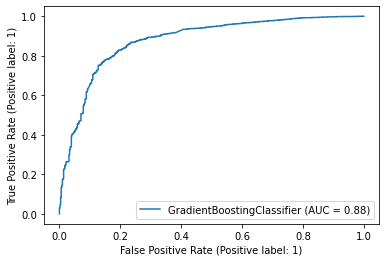

In [78]:
GB_disp = plot_roc_curve(GB, X_test, Y_test)
plt.show()

In [84]:
yhat = GB.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.872183, G-Mean=0.817


In [79]:
# filename = 'GB.sav'
# joblib.dump(GB, filename)
pickle.dump(GB, open('GB.sav', 'wb'))

# model = pickle.load(open('GB.sav', 'rb'))

In [210]:
import sklearn

# print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.3.


## phoBert

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import gensim
from vncorenlp import VnCoreNLP
import numpy as np

rdrsegmenter = VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

model = AutoModelForSequenceClassification.from_pretrained("bdh240901/phoBert-BigData")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\\\n\(\)]'

def remove_special_characters(batch):
    batch = re.sub(chars_to_ignore_regex, '', batch)
    return batch

def remove_number_characters(batch):
    batch = re.sub("\d+",'', batch)
    return batch

def remove_any_special_left(batch):
    # Loại bỏ các kí tự đặc biệt
    batch = gensim.utils.simple_preprocess(batch)
    batch = ' '.join(batch)
    # Sau khi loại bỏ kí tự đặc biệt thì file sẽ bị mất nhận diện chuỗi -> thêm dấu nháy vào chuỗi
    return batch

def segment_text(text):
    batch = rdrsegmenter.tokenize(text)
    if len(batch) == 0:
        return ""
    else:
        return " ".join(batch[0]).strip()
    
def softmax(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

def map_to_result(batch):
    print(batch)
    model.to("cpu")
    input_values = tokenizer(batch,return_tensors="pt", truncation=True).to("cpu")
    with torch.no_grad():
        logits = model(**input_values).logits
    # batch['label_id'] = torch.argmax(logits, dim=-1)
    # return batch
    return softmax(logits.numpy())[:,1]

def predict(text):
    text = segment_text((remove_any_special_left(remove_number_characters(remove_special_characters(text)))))
    model.to("cpu")
    input_values = tokenizer(text,return_tensors="pt").to("cpu")
    with torch.no_grad():
        logits = model(**input_values).logits
    # batch['label_id'] = torch.argmax(logits, dim=-1)
    # return batch
    return softmax(logits.numpy())[:,1]

In [15]:
test_df = pd.read_csv('test.csv')

In [16]:
test_df

,Content,label
0,thật_sự rất đáng tiền khi mua cuốn sách này để...,1
1,shipper giao hơi muộn tí thôi nha,1
2,xinh xịn dễ dùng giao hàng nhanh giá rẻ khoẻ thân,1
3,hàng okey nha mọi người bút mịn và không bị le...,1
4,túi to bên trong không chia nhỏ nên bảo_quản h...,1
...,...,...
3362,vừa nhận thẻ nhớ đã lắp thử vào máy và đều khô...,0
3363,vui_lòng kiểm_tra lại giúp mìnhnhư ban_đầu mua...,0
3364,xài mới dc tháng mà đồ bật bình nước bị hư rbấ...,0
3365,xe mới nguyên thùng nhưng thiếu ốc không lắp c...,0


In [17]:
test_df['predict'] = test_df['Content'].apply(map_to_result)

thật_sự rất đáng tiền khi mua cuốn sách này để học thêm ngoại_ngữ đặc_biệt là phần phrasal verbs vì nó là điểm ngữ_pháp đặc_trưng và rất khó của tiếng anh mà tất_cả người học phải vượt qua nếu muốn bước lên một tầm cao hơn trong học_vấn và cuốn sách này giúp_ích cho mình rất nhiều chẳng_những thế lại còn gọn_nhẹ và tiện_dụng để đem theo khi đi học nhẹ hơn cuốn oxford advanced learner dictionary nội_dung sách bao_gồm từ chính từ đi cùng với những giới_từ nào và điểm ngữ_pháp theo cùng có phiên_âm có từ_đồng_nghĩa để bạn biết khi nào nên dùng từ nào là đúng và có thêm ví_dụ để dễ học dễ nhớ cũng như một_số lời khuyên hữu_ích trong việc học và còn nhiều điều thú_vị mà các bạn có_thể tự khám_phá chúc các bạn học vui
shipper giao hơi muộn tí thôi nha
xinh xịn dễ dùng giao hàng nhanh giá rẻ khoẻ thân
hàng okey nha mọi người bút mịn và không bị lem qua_mặt sau giá không quá mắc nhưng chất_lượng thì cao người việt ưu_tiên dùng hàng việt
túi to bên trong không chia nhỏ nên bảo_quản hơi bất_tiện

bọn mèo rất thích
bút_bi này rất đẹp và dễ_thương và đúng như những gì quảng_cáo
bút_bi viết rất đều mực rất thích mình mua về để thưởng cho học_sinh các cháu rất thích
bút_chì dùng ổn chất_lượng tiki tranding thì khỏi phải bàn ngòi ra trơn đều dễ sử_dụng
bút_chì xài rất ổn viết chữ đều và sắc nét rất thích thương_hiệu pentel vì xài rất tốt từ lúc còn học cấp
bút chính hãng mực ra đều đẹp rất hài_lòng về cách giao hàng của tiki
bút cực_kì đáng iuuu luôn đủ màu nè lại còn rẻ nữa
bút cực_kì dễ_thương mực êmviết đẹp sẽ ủng_hộ shop
bút dễ_thương cực mực đều màu
bút dễ_thương lắm giao hàng cực nhanh
bút dễ_thương như quảng_cáo nè giao hàng nhanh cảm_ơn shop và tiki nhé
bút dễ_thương mực ra đều các bé nhà mình rất thích
bút đẹp mực đậm đều em sẽ luôn ủng_hộ tiki
bút đẹp đầy đủgiao hàng nhanh
bút đẹp lắm vừa dễ_thương chất_lượng cũng tốt shop đóng_gói cẩn_thận giao hàng nhanh sẽ tiếp_tục ủng_hộ shop
bút đẹp túi thì khỏi ns nhanhx mỗi_tội bút ưng vài cái và viết hơi đậmchả bt cs nhanh hết_mực 

chất_lượng tốt dùng nhẹ đơn_giản hơn các xoong thông_thường
châ lươ ng tuyê ha ng hô nhiê cho shop
chất_lượng tuyệt_vời màu rõ nét rất hài_lòng với sp này
chất_lượng và uy_tín của từ_điển oxford thì khỏi phải bàn bất_cứ ai muốn học tốt tiếng anh đều nên đầu_tư cuốn từ_điển oxford để học tốt thì biết nhiều từ_vựng là chưa đủ chúng_ta cần phải_biết cách dùng đúng collocation theo ngữ_cảnh oxford collocations dictionary rất hữu_ích trong việc cung_cấp các kết_hợp từ để sử_dụng trong văn viết và nói sao cho đúng chuẩn_mực từ_điển dày và nặng có kèm theo cd để cài_đặt trên máy_tính để sử_dụng dễ_dàng hơn
chất_lượng về nội_dung cả về ngoại_hình phải mới đúng tks happylive team
chats lượng bút nhật pentel rất tốt mình dùng dòng này từ cấp
cháu mình rất thích
chính hãng nhập_khẩu heneiken vn
chính hãng dùng tốt mượt đề_nghị tiki kích_hoạt bảo_hành giúp
cho sao lun cuốn này rất tiện nói_chung sau ngày dùng mk thấy nó okê lắm mà tra đầy_đủ ghê giải_thích cũng dễ hiểu chỉ một vì từ mình không hiể

cuốn từ_điển này có_thể xem như là người bạn đồng_hành cần_thiết là bất_kì ai học tiếng anh với mức_độ chính_xác cao dễ hiểu và nhỏ gọn mình đã sử_dụng nó từ năm lớp tới tận bây_giờ khi tốt_nghiệp đại_học và đi làm mình đánh_giá cao về phrasal verb mặc_dù từ_điển nhỏ cầm tay nhưng lại trình_bày hết_sức đầy_đủ về khoản này vì là từ_điển anh anh nên có_thể dễ tra từ_đồng_nghĩa từ_điển được trình_bày đẹp màu chữ xanh dễ tra chất_lượng giấy tốt
cuốn từ_điển này rất tuyệt giải_thích rõ_ràng có family words đầy_đủ
cuốn từ_điển rất hay dễ sử_dụng có_thể_tra xem danh_từ đếm được hay không đếm được cái form khác của từ nhưng mình nghĩ chỉ những bạn đã có một vốn từ căn bản mới nên mua cuốn này khi đọc định_nghĩa thì mới hiểu được
cute phô_mai que con tui muốn từ năm mà giờ mới có chơi hoài
đã dùng được một thời_gian rất thích sạch và đẹp
đã dùng hơn tháng rất tốt và đẹp có âm_thanh báo đun xong nên khá tiện
đã mua cái điện_thoại từ tiki trading đều là sản_phẩm nguyên seal sản_phẩm này pin rất t

điện_thoại chính hãng tốt mượt_mà giá rẻ giao hàng nhanh
điện_thoại đẹp giá_cả hợp_lý nhân_viên giao hàng thân_thiện
điện_thoại dùng ok nhờ shop kích_hoạt bảo_hành giúp
điện_thoại rất vừa giá tốt nữa rất thích
điện_thoại tốt giá hợp_lý nên mua
đỉnh luôn
đo người và lập lại thấy chuẩn lắm mà biết_bao hành năm có đúng hii
đồ_ăn cho mèo trưởng_thành meo vị cá_ngừ kg ok tốt
đồ_ăn cho mèo trưởng_thành meo vị cá_thu kgđồ ăn cho mèo trưởng_thành meo vị cá_thu kgđồ ăn cho mèo trưởng_thành meo vị cá_thu kgđồ ăn cho mèo trưởng_thành meo vị cá_thu kgđồ ăn cho mèo trưởng_thành meo vị cá_thu kgđồ ăn cho mèo trưởng_thành meo vị cá_thu kg
đồ_ăn cho mèo trưởng_thành meo vị hải_sản kg đồ_ăn cho mèo trưởng_thành meo vị hải_sản kg đồ_ăn cho mèo trưởng_thành meo vị hải_sản kg
độ_chính_xác cao pin trâu nhưng ko tặng kèm cục nguồn nên hơi buồn
đồ_chơi rất đẹp dù giao hơi trễ vì tết nói_chung là hài_lòng
đồ_chơi rất đẹp nhưng hộp bị méo chơi rất vui mọi người đều thích
đồ_chơi rất đẹp và đúng như muốn
đồ_chơ

game vui_vẻ nhẹ_nhàng dễ chơi nếu có bạn_bè lầy_lội hay bóp nhau thì nên tham_khảo thêm game siêu thú ngân_hà sắp ra_mắt nữa
gel chấm mụn hoạt_động vô_cùng hiệu_quả chấm lần là mụn giảm sưng tấy nhanh_chóng
gel đặc nhanh khô dễ lột
gel trong suốt xài thấy hiệu_quả là dịu mụn ửng và mới nặn của mìh rất thích
gia
giá_cả hợp_lí bút viết tốt không bị tắc
giá_cả hợp_lý hơn samsung bỏ vào camera hành_trình chạy tít
giá_cả hợp_lý tôi luôn tin_tưởng tiki mỗi khi mua hàng thầy_giáo guitar vũ trọng_long
giá_cả hợp_lý giao hàng nhanh hàng thì đóng_gói rất kỹ_càng luôn chống sốc chống va_đập mấy lớp luôn còn ghi kèm hàng dễ vỡ bên ngoài nữa sản_phẩm đẹp nấu nhanh độ bền thì chưa biết thế_nào thui tốt
giá_cả hợp_lý giao hàng nhanh hàng thì đóng_gói rất kỹ_càng luôn chống sốc chống va_đập mấy lớp luôn còn ghi kèm hàng dễ vỡ bên ngoài nữa sản_phẩm đẹp sản_phẩm đẹp nấu nhanh độ bền thì chưa biết thế_nào thui tốt
gia hàng nhanh đóng_gói cẩn_thận sản_phẩm đúng như mô_tả
gia hàng nhanh hàng mới nguyên_ch

giao hang nhanh tot va leco đoeu nv giao chưa ranh đương
giao hàng nhanh và chất_lượng
giao hàng nhanh bao_bì đóng_gói đẹp hàng sản_xuất tại malaysia chưa sử_dụng nhưng nhìn rất ổn
giao hàng nhanh bia uống ngon
giao hàng nhanh bút đẹp không bị lỗi
giao hàng nhanh bút nhiều hình dễ_thương cảm_ơn shop cảm_ơn tiki
giao hàng nhanh chất_lượng bài ok
giao hàng nhanh chất_lượng cao tôi rất hài_lòng về sản_phẩm của bạn bia tiger cho sao
giao hàng nhanh chất_lượng sản_phẩm tốt rất hài_lòng về tiki
giao hàng nhanh chất_lượng sản_phẩm tuyệt_vời
giao ha ng nhanh cho đươ ca me con va me lơ ăn
giao hàng nhanh chưa dùng nên chưa biết thẻ ntn
giao ha ng nhanh đă hô đêm ma hôm sau đa nhâ đươ đo ng go câ thâ nhân_viên giao ha ng dê thương sa phâ đe sư du ng râ tô đa ng tiê trong tâ gia sao
giao hàng nhanh đóng_gói cẩn_thận
giao hàng nhanh đóng_gói cẩn_thận đẹp dễ sử dụngđúng sản_phẩm khi đặt_hàng
giao hàng nhanh đóng_gói cẩn_thận nồi_áp_suất dùng cực tiện
giao hàng nhanh đóng_gói cẩn_thận sản_phẩm không

good
good book
good good tốt tốt tốt ok ok
good job
good product đẹp dễ_thương và sẽ tiếp_tục ủng_hộ
good tốt lắm giao hàng nhanh sao nha
good
good
good
good hàng chính hãngthanks shop
hai_long
hài_lòng
hài_lòng
hài_lòng
hài_lòng
hài_lòng
hài_lòng
hài_lòng
hài_lòng
hài_lòng
hài_lòng sẽ ủng_hộ tiếp giao hàng nhanh
hài_lòng về sản_phẩm nầy
hài_lòng về sản_phẩm nhận được đúng quy_cách mẫu_mã
hài_lòng về sản_phẩm trong mức giá này kiểu dây dù_cho cảm_giác chắc_chắn dịch_vụ đóng_gói cẩn_thận
hài_lòng về sản_phẩm
hài_lòng về sản phẩmấm dễ sử_dụng có nhiều chế_độ sôi
hài_lòng với chất_lượng giao hàng nhanh đóng_gói kĩ
hài_lòng với sản_phẩm bên tiki
hài_lòng với sản_phẩm đã mua chất_lượng tốt đồ mới đảm_bảo không gặp các vấn_đề gì khiến mình thất_vọng chơi cũng rất vui áo cũng đẹp nữa
ha lo ng vơ sa phâ đươ giao
ha lo ng vơ sa phâ đươ giao
hài_lòng với sản_phẩm hộp bút_bi thiên long tl xanh
hài_lòng với sản_phẩm này
hài_lòng với sản_phẩm cảm_ơn tiki
hài_lòng với sp nhưng phải đánh_đổi việc nhỏ

hàng nguyên seal dùng mượt giao hàng nhanh cam không đẹp cho lắm nhưng so với giá thì quá tốt
hàng nguyên seal giao tiki now nhanh giá ok chất_lượng thì hàng điện_tử hên xui thôi
hàng nguyên sell rất ok nho tiki kick hoạt bảo_hành giùm luôn
hàng nhìn đẹp đỗ nước đầy ấm phút là sôi dùng cả tuần nay rồi mới đánh_giá hiện_tại chưa phát_sinh vấn_đề gì cả nhân_viên giao hàng tốt chờ dùng thử thấy ổn rồi mới đi
hàng như hình đóng_gói kỹ hạn_dùng dài rất ưng
hàng như mô_tả chính hãng
hàng ok đúng loại đã đặt
hàng ok lắm
hàng ok nguyên seal nhé bà_con
hang ok cam on dhop nhe
hàng ok đc mua kèm quà cảm_ơn tiki
hàng ok sản_phẩm giống mô_tả cảm_giác rất an_toàn
hàng ok xài rất ổn mua hàng philip nên yên_tâm đã dùng lần ổn
hàng ổn đóng_gói tốt nhưng ko thấy cái gói tặng khoá nhiếp_ảnh đâu nhỉ
hàng order giao nhanh chất_lượng tốt
hàng quá tốt_đẹp
hàng rất đẹp
hàng rất là ok nhưng mình về đổ nước vô nấu thì nó bóc hơi lên mùi giống như mùi cống lắm có ai như tôi và chỉ tôi cách khắc_phục
hàng rất ok

khi nấu nước có màu xanh đẹp dễ dùng nấu nước nhanh bình thuye tinh trong nhưng cầm_chắc chắn
khi tôi nhận được cuốn oxford pocket này tôi rất thích vì nó rất tiện_lợi có_thể mang đi bất_kì nơi đâu pocket chứa gần như đầy_đủ tất_cả các từ và các ví_dụ rất là hữu_ích trang bìa được thiết_kế với tông màu xanh nhìn vào rất dễ_chịu và sang_trọng được đánh_dấu với các chữ_cái rất dễ_dàng trong việc tra từ với mức giá_như thế_thì pocket đã không làm thất_vọng người mua đối_với những_ai đang học tiếng anh thì đây quả_thực là một quyển từ_điển cần_thiết
không biết bé có thích ăn như những loại khác không nhưng_mà giao hàng nhanh sản_phẩm date xa nên hài_lòng
không biết con_em đi đâu lôi về quyển sách xong nói bà đọc đi chứ thấy bà chưa biết quản_lý tiền_bạc gì cả ban_đầu không định đọc mà lật vài trang thấy hay quá nên ngồi một_mạch từ tối đến sáng được phần sách hay nội_dung chất_lượng và mình đang định đặt thêm vài quyển tặng cho bạn_bè
không cần nói nhiều về cuốn này nữa anh_chị_em nào học 

máy đo tốt chính_xác dễ sử_dụng
máy đo tốt mua ngay đợt sale rẻ mà_còn được tặng quà siêu to nữa giao hàng thì cực nhanh mới đặt tối_qua mà tối mai nhận được rồi cám_ơn tiki nhiều
máy đun nhanh bền đẹp và đặc_biệt là ko có mùi hôi dùng rất thích
máy dùng chíp chạy rất mượt pin rất trâu mua đợt giảm_giá còn trk bản ram bộ_nhớ
máy dùng khá mượt hàng nguyên đai nguyên kiện không một lỗi gì mua cái bao da bỏ vô nữa là ngon
máy dùng mượt màcòn pin trâu đến đâu phải dùng thử xem bao_lâu mới sạc đã hàng chính hãng digiword
máy dùng mượt chưa có gì để phàn_nàn tiki giao hàng nhanh đóng_gói cẩn_thận và an_toàn
máy dùng tốt đo nhanh và chuẩn đây là lần mình mua máy trên tiki rồi
máy dùng tốt nha mn rẽ hơn giá chính hãng máy này xách tay bản za
máy dùng tốt đo chính_xác trước khi chuẩn_bị đo mọi người nên ngồi nghĩ tầm không dùng chất kích_thích như rượu_bia trước khi đo để cho ra kết_quả chính_xác nhất nhé
mấy dùng tốt giá_cả hợp_lý có bảo_hành
máy dùng tốt giao hàng là có hàng đo chính_xác tron

mình đã mua và sử_dụng được một thời_gian nồi dùng rất thích nấu cháo hầm xương hay nấu xôi đều ngon mua đợt km giá tốt nên cảm_thấy hài_lòng
mình đã nhận đc hàng sp rất tốt mình sẽ ủng_hộ shop
mình đã nhận được hàng và rất hài_lòng về sản_phẩm chất_lượng dịch_vụ của tiki nhờ tiki kích_hoạt bảo_hành giúp mình nhé vì mình đã tự gửi mã imei về nhưng mãi mà không thấy phản_hồi khi check trên website của samsung thì vẫn thấy là điện_thoại của mình chưa được kích_hoạt bảo_hành tiki hỗ_trợ kích_hoạt bảo_hành giúp mình nhé cảm_ơn tiki nhiều
mình đã nhận sản_phẩm đặt_hàng tối thứ sáng chủ_nhật đã nhận hàng sản_phẩm như mẫu về hình_thức thì với tầm giá chưa đến tr thì rất là ok màn_hình lớn mình mua màu trắng ngọc_trai nên khá đẹp giao hàng nhanh chưa sử_dụng nên chưa đánh_giá chất_lượng vài ngày nữa mình sẽ đánh_giá về chất_lượng sau nhé nói_chung hài_lòng với gb thì người lớn_tuổi dùng để gọi nghe xem youtube gọi video màn_hình thì tầm giá này là hợp_lý
mình đang chờ hàng đến sau mấy tháng th

mình mua tặng mẹthấy rất tuyệt_vời vì bà dễ sử dụnggiá lại hợp_lý khi mua trên tiki rẻ hơn thị_trường
minh mua và thấy đo tốt muốn mua bộ sạc cho máy mong shop hỗ_trợ
mình mua về cho mấy đưa học_trò toàn_bộ là mực đen chất_lượng ok
mình muốn mua đĩa cài_đặt ko mua sách có được ko vì đĩa mình đã hết hạn năm
mình nhận được bộ màu hồng bút đen bút viết đẹp nhưng mau hết_mực
mình order thứ thứ tuần sau đó nhận được ấm đun nhanh êm không gây ồn thân ấm khi đun rất nóng đấy bạn nào nhà có trẻ_em nhớ tránh xa tầm tay tụi nhỏ đóng_gói chắc_chắn bảo_hành rõ_ràng tốt
mình rất hài_lòng chơi rất vui bản_đồ siêu đẹp
mình rất thích chơi rất vui nhưng phải chơi cùng với nhau từ cho đến bạn
mình rất ưng về đóng_gói mẫu_mã của sp chụp đk đủ sáng cũng được nghe tiếng rõ truy_cập mạng khá ổn nchung với giá này thấy rất hơpj lý cho người già dùng ít ứng_dụng
mình rate sao vì hàng xịnđóng gói cẩn_thận mình mãi mới có người chơi
mình siêu hài_lòng luôn sản_phẩm đủ màu đủ kiểu cảm_ơn tiki
mình sử_dụng được t

mua đã lâu giờ mới viết nhận_xét dùng rất thích tốc_độ nhanh
mua điện_thoại cho bố nói_chung bố mình không dùng gì nhiều đọc báo nghe gọi xem video đồ thôi dùng ngày mà_còn hơn
mua điện_thoại hết tr mà có bao_gồm cả ốp lưng tai nghe kèm theo cặp đệm cao_su để thay_đổi kích_cỡ điện_thoại có cảm_giác hơi nặng_tay chắc do pin khủng cầm điện_thoại đi khoe vs mọi người ai cũng tưởng mình mua hết tr hay tr lúc nói chỉ có tr ai cũng bất_ngờ camera thấy mọi người bảo ảnh chụp của vsmart kèm mình dùng thì thấy bình_thường chắc mình không yêu_cầu cao về khoản nàytổng quan điện_thoại đạt yêu_cầu của mình từ giá bán cho đến sử_dụng hàng việt_nam xứng_đáng được ủng_hộ
mua đợt săn sale nên ship về thanh_hoá hết hơn xíu rất hài_lòng kể cho mua lại với giá đó thêm thì ngon
mua đợt giảm_giá nhưng vẫn là còn khá cao tuy_nhiên tiền_nào_của_nấy bôi lên là có cảm_giác thuốc tác_động lên vết mụn luôn hiệu_quả không ngay_tức_thì nhưng sẽ thấy dần theo ngày srm cũng ok lắm sạch_bong và không gây khô mọi người

nồi_áp_suất hầm mềm rất ưng
nói_chung thì ổn giao hàng không quá nhanh nhưng không trễ thẻ nhớ gb này phù_hợp với nhu_cầu cho camera giám_sát hoặc cho điện_thoại quay_phim chụp ảnh full hd chứ quay thì thẻ này không hợp
nói_chung vs tầm giá thì tương_xứng thôi
nồi dễ sử_dụng tiki giáo hàng nhanh hàng chất_lượng
nồi đến từ thương_hiệu philip thì rất yên_tâm dùng rất tốt thêm điểm cộng nữa là tiki bán giá hợp_lý hơn các chỗ điện_máy khác
nồi đẹp dễ xài lòng nồi có_vẻ mỏng nhưng chắc không sao nhưng đọc hdsd thì thấy không được bỏ đòi ăn ít hơn lòng nồi cho mình hỏi trường_hợp hầm cháo cho bé ít thôi_thì làm_sao
nồi đẹp thiết_kế tinh_tế và duyên_dáng sản_phẩm cầm thấy chắc_tay dễ sử_dụng rất hài_lòng
nội_dung của cuốn từ_điển thì khỏi phải bàn chỉ muốn nói là tiki làm_việc rất hiệu_quả và năng_suất rất cao cám_ơn tiki nhiều
nội_dung hay thì khỏi phản bàn khá dày_dặn khổ nói_chung là tốt chăm học sẽ lên trình
nội_dung kiến_thức trong sách phong_phú sát với thực_tế việt_nam các ví_dụ trong 

quyển sách tài_chính đọc dễ hiểu nhất mà mình từng đọc cũng muốn dấn_thân và kinh_doanh nên mình tìm đọc những quyển sách kinh_tế quyển của lâm minh chánh mình thấy thiết_thực nhất
quyển từ_điển anh anh đầu_tiên của tôi một quyển sách thật_sự rất hữu_dụng nhất là với những bạn học tiếng anh nâng cao hoặc ôn thi ielts toefl tăng khả_năng sử_dụng và mở_rộng vốn từ_học tiếng anh khó nhất là khi mình muốn diễn_tả điều gì đó khi nói hoặc viết mà không biết nhiều từ mới đều phải dùng lặp_đi_lặp_lại các common words nhưng từ khi mua được em dic này về mình chẳng phải lo_lắng gì nữa từ được giải_thích ngắn_gọn dễ hiểu kèm thêm cách phân_biệt khi nào dùng từ này khi nào dùng từ kia cho phù_hợp với quy_tắc và ngữ_cảnh như kiểu phân_biệt sự khác nhau giữa wicked và evil ấy làm khả_năng học và vốn hiểu_biết tăng lên rõ_rệt đồng_thời bổ_sung khá nhiều cho mình về phần collocations và patterns các ví_dụ đúng_sai rất cụ_thể từ_điển lại khá nhỏ gọn mình toàn cho vào túi áo khi đi học giấy khá dày đẹp 

sách có nội_dung khá hay và bổ_ích cho những người đang muốn tìm_hiểu các nguồn đầu_tư như mình
sách có rất nhiều từ_vựng cấu_trúc chặt_chẽ dễ tìm từ mình cần có phiên_âm và định_nghĩa giải_thích bằng tiếng_anh
sách có thiết_kế rất đẹp nội_dung sẽ được review khi đọc xong tks happy live
sách của anh thái phạm của happylife thì chất_lượng phần_cứng của sách thì khỏi_phải_nói hơn_nữa trình_bày đẹp nội_dung được những người trong ngành dịch nên rất dễ hiểu và sát thực chứ không mông_lung
sách của oxford nên khỏi chê về mặt nội_dung rồi sách mới tuy có chút nhăn mép bìa nhưng sao
sách đẹp
sách đẹp đóng_gói và in_ấn cẩn_thận
sách đẹp đúng chất_lượng của oxford giao hàng và gói cẩn_thận vote cho tiki sao
sách đẹp ae nên đọc lần
sách đẹp chất_lượng sách tốt
sách đẹp chưa độc nội_dung nhưng khá đáng tiền
sách đẹp đóng_gói cẩn_thận ko bị rách hay hư_hỏng
sách đẹp đóng_gói gọn_gàng kĩ_lưỡng sách mới
sách đẹp được gói trong nilon cẩn_thận đáng đồng_tiền_bát_gạo
sách đẹp giấy tốt giao hàng hơi lâu

sản_phẩm có thơm mùi cá mèo nhà mình rất thích ăn nhiều sẽ ủng họ shop trong những ngày tiếp_theo
sản_phẩm có_vẻ lỏng_lẻo xước nhiều chỗ có_vẻ như bị khui ra và sử_dụng rồi
sản_phẩm còn nguyên seal bao_bì chắc_chắn chờ cuối tuần chơi cùng anh_chị_em thôi
sản_phẩm của oxford thì khỏi phải chê giấy đẹp mà nội_dung thì rất hữu_ích cho người học lại là phiên_bản pocket nên rất tiện mang theo đi học rất hài_lòng
sản_phẩm cực ổn_định trong mức giá_sử_dụng ổn pin dùng được khá lâu giao hàng nhanh nguyên seal thiết_kế kim_loại hiện_đại dù có khuyết_điểm nhỏ là mặt lưng dễ bám mồ_hôi và vân tay
sản_phẩm đa_dạng mẫu_mã đẹp bút viết mực êm và ra đều màu
sản_phẩm đã mua dùng hơn một tuần rất tốtcực kì hài_lòng
sản_phẩm đang dùng tốt giả rẻ so với giá_trị hi_vọng bền
sản_phẩm đầy_đủ đóng_gói hàng tốt
sản_phẩm đầy_đủ giao hàng nhanh
sản_phẩm dễ sử_dụng đóng_gói cẩn_thận giá rẻ hàng omron xài rất thích
sản_phẩm đẹp màn_hình sáng trắng trắng_tinh không trắng vàng như vsmart joy gb như tôi đang dùng và

sản_phẩm rất được đóng_gói rất kĩ thật_sự hài_lòng với tiki mình sẽ ủng_hộ shop nữa
sản_phẩm rất hữu_ích mình có_thể học từ_vựng bất_cứ nơi nào nhỏ gọn tiện_lợi dễ mang đi theo bên mình
sản_phẩm rất ok
sản_phẩm rất ok giao hàng nhanh chưa tới ngày đã nhận đc hàng mong các sản_phẩm khác cũng giao nhanh như_vậy cảm_ơn shop
sản_phẩm rất ok giao hàng nhanh dịch_vụ tốt có nhu_cầu luôn ủng_hộ
sản_phẩm rất tốt
sản_phẩm rất tốt chỉ là khâu dóng gói hơi tệ nhé
sản_phẩm rất tốt an_toàn và đẹp thank you very much
sản_phẩm rất tốt nhé mn bao_bì chắc_chắn chất_lượng còn mới còn nguyên bút êm ra đều mực màu lên chuẩn lắm luôn cảm_giác như mình đến cửa_hàng được chọn_lựa sản phẩmvậy cảm_ơn shop và tiki nhé
sản_phẩm rất tốt như mình mong_đợi
san pham rất tốt toi rất hai_long
sản_phẩm rất tốt game rất hấp_dẫn áo chất_lượng tốt mặc vào rất mats
sản_phẩm rất tốt giá hợp_lý sẽ tiếp_tục ủng_hộ tiki
sản_phẩm rất tốt hiện_tại không có lỗi nào cả
sản_phẩm rất tốt rất đáng đồng_tiền bác gạo cảm_ơn nhiều
sản_ph

size nhỏ gọn nhưng nội_dung vẫn đầy_đủ chi_tiết chất_lượng in rất tốt tiki giao hàng đúng như dự_kiến
so good fast delivery
số_liệu cũng tạm ổn dùng để đo hàng ngày tốt theo_dõi liên_tục
so với joy thì là sự phát_triển rất tốt joy cũng được năm mà vẫn xài ổn còn joy này để thời_gian sử_dụng mới đánh_giá hoàn_chỉnh
sp chuẩn chưa active nguyên serial tuy_nhiên tiki rất vớ_vẩn sale ngày có cả mã giảm_giá là lại đắt hơn cả ngày thường hiện_tại ngayd hôm_nay check giá hiện_tại là
sp của thiên long thì ko chê vào đâu được sử_dụng tốt bà mượt_mà mua ngay đợt sale tính ra chỉ có cây
sp đạt tiêu_chuẩn hài_lòng về chất_lượng sản_phẩm
sp đc gói rất kỹ và chuyên_nghiệp đã sử_dụng đc ngày mình xài rất là thích nấu rất là nhanh soi khi để rất an_toàn ko như những bình đun nhãn_hiệu khác
sp đẹp xài đã lắm
sp đẹp đóng_gói cẩn_thận giao hàng nhanh hơn dự_kiến
sp đẹpmàu sắc bắt_mắt bé nhà mình rất thích ủng_hộ shop
sp đúng như hình giao hàng nhanh đã sử_dụng được tháng rất ok nồi này hầm thịt nấu súp si

thùng bia được bọc rất kỹ hàng giao nhanh hơn dự_kiến rất tốt
tiết_kiệm nếu mua bịch lớn này
tiger chính hãng thùng mới nguyên gói cẩn_thận giao hàng cực nhanh
tiki đóng_gói cẩn_thận bình_thuỷ tinh mình cũng sợ lúc đặt_hàng nhưng tin_tưởng hệ_thống logistics của tiki bình có chế_độ giữ nóng có các nấc đun nhiệt_độ khác nhau nên rất tiện_dụng
tiki đóng_gói cẩn_thận đúng sản_phẩm đặt_hàng giao hàng nhanh tầm đã nhận được hàng hàng mua đã kiểm_tra hình_thức và chất_lượng ban_đầu ổn chất_lượng cần thời_gian trải_nghiệm thêm để đánh_giá thanks tiki team
tiki đóng_gói cẩn_thận giao hàng đúng hẹn hàng chính hãng
tiki đóng_gói cẩn_thận giao hàng nhanh hơn những gì mình mong_đợi tiếc là mình mua lúc tiki không có chương_trình km nên giá không được tốt mình yên_tâm với sản_phẩm của lock amplock
tiki đóng_gói cẩn_thận sản_phẩm dùng tốt đo tương_đối chính_xác
tiki đóng_gói hàng kĩ có xốp và giấy bong_bóng tuy_nhiên có hộp tiki và hoá_đơn máy tốt_số khá đúng với bác_sĩ từ ngày tiki chuyển đối_tác g

tôi có mua bộ siêu thú ngân_hà cho con tôi nhưng khi mở ra kiểm_tra thì chỉ có lá bài sự_kiện không giống như mô_tả thành_phần trò_chơi là có lá sự_kiện con tôi không hài_lòng với món quà sinh_nhật này mong board game việt_nam hỗ_trợ bù lại lá sự_kiện khác
tôi cực_kì hài lòngtôi siêu siêu hài_lòng đó là món quà sinh_nhật của con tôi nó rầt thích
tôi cùng cả nhà tôi chơi cảm_thấy rất vui và bổ_ích
tôi đặt màu trắng mà shop giao màu xanh ko biết cố_tình hay do nhầm_lẫn nữa còn máy thì tốt rồi
tôi đặt được tuần rồi nói là tuần trước giao mà tới hôm_nay chưa có nữa mong tiki giao hàng nhanh
tôi đặt_hàng từ mà chưa có tôi đã sắp lịch để nhà đợi hàng và thì vỡ kế_hoạch rất nhiều thứ đặc_biệt là ko huỷ dc đơn hàng
tôi đặt mua bình đun vì nó đang đợt giẩm giá của locknlock nhận hàng cảm_thấy mọi thứ đều oke nói_chung là hài_lòng so với giá này
tôi dùng một chiếc rồi chiếc này mua thêm là chiếc thứ
tôi hài_lòng đối_với chất_lượng hàng và việc giao hàng của tiki
tôi hài_lòng khi mua quyển này và

từ_điển của oxford là khỏi chê rồi sách dành cho dân ngôn_ngữ hay muốn đào sâu hơn về tiếng anh song_ngữ anhanhviet làm cuốn sách rất có giá_trị
từ_điển của oxford thì ko cần bàn về độ chuẩn_xác trong phát_âm và giải_thích ngữ_nghĩa đằng sau những từ quan_trọng còn có cả phrasal verb và idioms cực_kì hữu_ích cái này rất quan_trọng dễ_dàng mang theo người và dễ_dàng tra_cứu các ký_hiệu viết tắt dễ hiểu vì hàng amazon nên giá hơi cao nhưng bù được chất_lượng giấy và gáy sách thì rất tốt
từ_điển hữu_dụng vừa đủ để mang theo học_tập nhưng hơi thiếu nhiều từ bạn nào muốn nghiên_cứu kỹ hơn chắc phải mua hẳn cuốn to bự
từ_điển này rất nhỏ gọn nội_dung cũng rất hữu_ích giúp rất nhiều trong việc trau_dồi thêm vốn từ_vựng sách giao nhanh rất hài_lòng
từ_điển nhìn nhỏ nhưng rất tiện kho từ rất rộng và còn phân ra nhiều loại từ có keyword dễ_dàng sử_dụng để học và tra từ nói_chung từ_điển rất đáng mua đối_với những bạn học tiếng anh và có vốn từ nhất_định
từ_điển nhỏ gọn cầm vừa tay các từ_đồng_ng

viết trơn mực đều chỉ có cái ruột mực hơi ít
vỏ đựng có miếng nhựa giúp đựng bút cố_định nên mình rất thích màu cả đầu lên rất đều và rõ có màu xanh lá hơi nhạt xíu giá_cả phù_hợp mua trên tiki còn giảm_giá nữa
với giá tiền như thế_này mà được con máy_ảnh với thông_số chi_tiết cao như của máy_ảnh sony dsc megapixel zoom thì thật là tuyệt_vời cám_ơn tiki khuyến_mại với nhiều quà tặng trong ngày big friday với chính_sách trả_góp lãi_suất rất phù_hợp với những viên_chức nhà_nước như mìnhmình hy_vọng đây là món quà nghĩa cho cậu con trai thích chụp ảnh nhà mình
với nhu_cầu xem phim lướt web đọc sách như mình thì sản_phẩm này phù_hợp tuy_nhiên vs cấu_hình như_vậy thì đôi_lúc chạm vào màn_hình phản_ứng hơi lâu
với những người có tiền_sử về huyết_áp thì lựa_chọn một chiếc máy đó huyết_áp để trong nhà là một sự cần_thiết máy đo huyết_áp điện_tử dễ_dàng sử_dụng kể_cả với những người lớn_tuổi không quá khó để có_thể lấy được số_đo chính_xác rất hài_lòng vì bên tiki giảm_giá rẻ hơn giá thị_trường

bút đẹp viết trơn hình dễ_thương giá lại rẻ nên mua
bút dùng tốt giao hàng tốt sản_phẩm gói hàng tốt
bút hơi bụi chắc do tiki để lâu trong kho nhưng mk bấm thử thì rất chắc
bút hơi mềm nên khó ghi cho người mới tập calligraphy
bút mới viết ok nhưng hộp hơi nát
bút nhiều hình đẹp cute có_thể tặng nhưng mực ra hơi nhiều nhưng với giá đó thì được
bút nhiều màu_sắc
bút như mô_tả mực đều và đẹp rất ưng sản_phẩm hih
bút okie viết được nhưng hơi đậm đóng_gói kĩ giá_như thấy này là okie lắm rồi
bút ra đều mực nhưng khá nhanh hết mưucj
bút rất đẹp viết rất êm nhưng mình nghỉ shop nên cho bút mực xanh thì phù_hợp vs học_sinh hơn
bút rất xinh mực viết êm và đều không bị đứt khúc rất hài_lòng vì bút xinh và giá cực rẻ
bút thì xinh viết đẹp giao hàng nhanh nhưng_mà giao cho mình toàn peppa hơi buồn
bút viết rất thích mẫu_mã đẹp giá_cả lại phải_chăng
bút viết tốt không bị trùng hình nhưng một_số hình không đc hoàn_thiện như mất mắt mất tai
cả nhà mèo đều khá thích
các bác đã dùng máy này cho em hỏi_

đc
dễ hiểu xúc tích đáng để mua và đọc
dê thương châ lươ ng kha tô giao đu sô lươ ng
dễ_thương mực viết tốt nhưng sau bút bị chảy mực
đèn led đổi màu theo mỗi mức nhiệt_độ đun sôi nhanh có chế_độ tự khởi_động lại khi nhiệt_độ trong ấm tuột xuống mức xác_định điểm trừ duy_nhất mình ko cho là vì nhìn vào đáy ấm dưới lớp kính có vài chấm nhỏ giống rỉ sét hy_vọng chỉ là quá_trình gia_công xi hàn thế_nào bị dính dị_vật chứ ko phải rỉ sét thật_sự
đẹp nhưng nhiều nhân_vật quá ko cần_thiết
điện_thoại ổn tuy_nhiên ko có tai nghe kèm theo
đồ_chơi rất thú_vị và vui
đo tốt chỉ_số thay_đổi nhiề
đo không đươ do chư nho qua ci shop nên ghi chu điê na vi co sa ch nho nhưng chư vâ lơ hơn
đóng_gói cẩn_thận đúng trong ảnh nhưng không hài_lòng lắm vì sp đến vào buổi trưa lúc mà mình đang ngủ mà lần sau giao hàng thì tiki nhớ đứng đầu ngõ thôi nhé vẫn cho sao vì giao hàng nhanh đấy
đóng_gói cẩn_thận kiểm_tra máy ok chờ thời_gian sử_dụng mới đánh_giá dc
đóng_gói cẩn_thận giao hàng nhanh mua giùm bạn nên biế

hộp mua hơi nhàu nhưng bình đẹp xài tốt đun nóng nhanh
hút được các mụn nhỏ liti cảm_giác sạch_sẽ đi nhiều mùi hơi hắc lúc mới thoa thời_gian khô hơi lâu hợp_lý trong giá tiền
có đĩa cd
khá hài_lòng
khá ok so với giá
khá ok
khá ổn dễ vệ sinhgiữ nhiệt kém
khá tốt giao hàng nhanh mà nói gửi bút lộn_xộn sao chỉ có mỗi màu mực đen viết toàn màu vàng rất dễ_thương
không tốt bằng cái đầu mua nhưng cũng tạm ok
kiểu_dáng đa_dạng xinh_xắn bắt_mắt với trẻ điểm trừ là có nhiểu bút trong hộp bị bung nắp và thú được gắn trên nắp nên dán lại hơi cực
kiểu_dáng đẹp đèn led báo nhiệt_độ đun sôi tiện_dụng giá mềm sau khuyến_mãi tuy_nhiên vỏ thuỷ_tinh ko cách_nhiệt chạm tay vào rất nóng cảm_giác thiếu an_toàn khuyến_cáo tránh xa trẻ dưới tuổi
ko chỉ có mèo con mà mèo lớn nhà tôi cũng thích ăn loại này
ko có nhà xản suốt
ko có nút mở nắp
làm_sao để đèn led nhiều màu sáng lên vậy ad
làm_sao để kích_hoạt bảo_hành
làm_sao để nghe nhạc trong thẻ nhớ mình cài vào nhưng chỉ xem được ảnh
lần đầu mình mua trên mạ

mình đặt giao nhanh giờ nên giao rất nhanh không dùng được cho camera ip không định_dạng được khi gắn vào camera trên điện_thoại thì ok tem bảo_hành quá lớn khi nên khi gắn vào khay thẻ nhớ trên điện_thoại sẽ bị rách phần không biết sao này nếu hư có bảo_hành không_chỉ có vấn_đề đó thôi còn lại thì ok hết
mình được cô tiếng anh giới_thiệu và tìm mua khổ_nỗi mình lục mãi các nhà_sách mà vẫn có cũng nhờ có tiki bán cuốn này là loại_bỏ túi nên dĩ_nhiên là nhỏ và chữ in cũng nhỏ nên mọi người cứ chê nhưng vs mình như_vậy là tốt nó giúp mình khá nhiều việc các bạn muốn thêm nhiều từ hơn thì có_thể mua những loại khác đã sử_dụng và cảm_thấy hài_lòng về cách phục_vụ của tiki giao đúng hẹn và gói cũng khá kĩ mọi người nên sử_dụng quyển này nếu còn đi học và cần tra một_số từ đơn_giản
mình không phải là người quá cầu_toàn nên có một_vài nếp gấp chỗ gáy sắc cũng không khiến mình không mấy khó_chịu nên bỏ_qua được nhưng vấn_đề là chữ được in quá nhỏ nếu không mở sách ra đến tận gáy thì không thấy

nấu nước mau sôi tốt ôk
ngẩu nhiên sao đên cây màu đen và xanh thôi mình nghĩ ngẫu_nhiên về màu_sắc bên ngoại thôi chứ không thích màu đen
ngon bổ chưa rẻ
ngon_lành
ngon bổ rẻ và hàng việt_nam hơi buồn là chưa có hệ_thống cung_cấp dịch_vụ rộng khắp nên sửa_chữa thay_thế phải mang về hà_nội
nguyên seal ko thấy phiếu bảo_hành về các chức_năng của điện_thoại pin camera thì tốt hơn tầm giá mình đã mua cái điện_thoại tiki tranding có_lẽ vì samsung ko bền như iphone cái cũ mình mua là dùng được hơn năm hỏng mic ko nghe gọi được nên mình phải mua mới dù_vậy mình vẫn chọn mua tiki lần nữa hy_vọng lần này dùng được láu hơn
nhăn hơi quăn xước màu quá sáng so vs quy_định tui không hề hài_lòng một_chút nào cả
nhâ ma thi ok nhưng sao mi nh không thâ co tai nghe ke theo vâ
nhận sách về hài_lòng lắm sách đẹp và nhân_viên giao hàng nhanh_chóng tiếp_tục ủng_hộ tiki
nhân_viên giao hàng nhanh tận_tình sách hay tuy_nhiên giấy hơi mỏng
nhiều tính_năng tiện_ích
nhìn_chung bình nấu nước khá ổn nếu có công_tắ

sản_phẩm hài_lòng
sa phâ ha lo ng co tă ng ke pin nhưng hi nh nh tiki đưa ra ko đu ng nên thay đô hi nh nh minh ho sa phâ đô đeo bă tay la ma xa chư ko pha ma đen như tiki đưa ra ma đen gia cao hơn ma xa
sản_phẩm hình_thức tương_đối tốt nút bấm còn khá lỏng_lẻo
sản_phẩm hoàn_hảo ngoại_trừ việc hệ_điều_hành xung_đột với trình_duyệt nhân chromium khiến màn_hình thường_xuyên tự_động ám vàng bạn nào bị tình_trạng trên có_thể disable mục dynamic color gamut trên chrome flags
sản_phẩm khá tốt ngoài việc phải mua thêm pin sạc aa cho máy mình chia_sẻ cho các bạn một_vài bức ảnh mình chụp bằng sony dsc
sản_phẩm này tốt cho người học phổ_thông intermediate đọc dễ hiểu hơn nhiều so với cuốn advanced hơn_nữa rẻ nhỏ pocket sized giấy chấp_nhận được
sản_phẩm ngắn_gọn súc_tích dễ hiểu nhưng cở chữ nhỏ quá nên đọc ban_đêm rất mỏi_mắt
sản_phẩm nguyên seal chính hãng tuy_nhiên với cách giao hàng ngày thì cho sao tiki nên khắc_phục cách giao hàng để cạnh_tranh với các dịch_vụ mua_sắm online khác
sản_phẩm

tiki giao hàng nhanh hỗ_trợ nhanh_chóng rất hài_lòng về khâu chăm_sóc kh máy tb mua cho bé dùng máy xài ổn so với mức tiền
tiki giao hàng trễ dù đã đặt giao hàng nhanh nhân_viên giao hàng báo là lấy thiếu hàng nên dời sang ngày hôm sau không hài_lòng lắm về lý_do ngày hôm sau cũng phải tới chiều mới giao hàng trả phí giao hàng nhanh trong thành_ra giao hàng trong vòng hơn ngày
tiki giao nhanh nhưng màu khi vẽ viết ra thì hơi ít mực bút khá đẹp ok hợp với giá tiền
tiki giao nhanh hơn dự_kiến bút mực đen viết đẹp hình đáng iu túi bút xinh tuy_nhiên set mà chỉ giao
tiki ơi tài_khoản của mình còn bìa bọc bookcare nhưng sao cuốn sách này không bọc cho mình hỗ_trợ mình với
tớ mua thùng bia tiger chất_lượng ok lần sau tất_nhiên mua nữa
toàn_bộ bút đều là mực đen có đầu bảo_vệ khá tốt nhưng điểm trừ là bên shop giao thiếu cho mình chiếc bút cả set đều là màu tím hết
toàn màu đen nhưng chất_lượng ổn
toàn viết đen mong tiki hãy giao viet xạn hoac đoe
tốc_độ đọc ghi hơi thấp số với quang cáo nhưn

bút nhùn đẹp nhưng lại mực đen dễ chảy mực lại ko có đầu niêm_phong bút
bút thì giống hi nh nhưng không có túi đựng bên ngoài như trong hình thay vào đó là bịch trong suốt
bút viết thick mẫu_mã đẹp nhưng ko ghi rõ màu mực nên khi nhận hàng hơi bị thất_vọng vì mực đen
cái nắp hơi lởm chút nấu đồ_ăn tạm chấp_nhận dc so với giá thì ổn
cám bị ỉu
cảm_giác sách hơi giả giả
camera thật_sự tệ so với tôi nghĩbắt sóng với wifi thì rất yếu còn lại thì cũng khá ok
cấu_hình đúng mô_tả máy nguyen tem mác sp đầy_đủ sạc tai nghe và ốp trong tuy_nhiên máy chạy rất chậm và đơ
chán chả muốn nói luôn vận_chuyển thì lâu mà_còn rách_rưới được cái mèo thích ăn nên gỡ cho
chất_lượng như giá tiền nói_chung dùng cũng ổn
chất_lượng túi đựng máy không như mong_đợi giao hàng trễ ngày nếu không gọi chắc còn trễ hơn_nữa máy_ảnh chụp rất tốt
cho mình hỏi là ngày sx hay hsd vậy sao lại dán tem đè lên
cho vào đt kg chuyển ứng_dụng sáng đc
chưa sài như nhìn hình_thức bên ngoài khá là ok mong là sài sẽ ok như mình nghĩ
c

máy xài tạm ổn nếu muốn chơi game mượt thì đầu_tư thêm vnđ mua thanh ram gb của samsung lắp thêm sử_dụng sẽ ổn hơn nhiều màn_hình gọi là tốt cho cấu_hình chơi game đồ_hoạ chuyên vể hình_ảnh và màu thì sẽ không được tốt máy_tính vừa tầm giá cho anh_em sử_dụng cày game và xem phim thích_hợp với mấy bạn viết web chúc anh_em chọn được máy_tính ưng
mình cho sao là bởi_vì sản_phẩm giá_trị cao nhưng trong hộp không có chèn lót gì cả giao hàng sai hẹn lần vì đầu_tiên đặt_hàng thứ nhắn giao trong vòng nhưng mãi thứ mới giao gt
mình cứ nghĩ sẽ đc các hình xinh_xẻo nhưng lại là hình lợn bằng silicon khá mỏng bút thì nhỏ và ít mực ngòi rất nhỏ mình mua với giá sale chứ giá gốc như này thì hơi quá
mình hay mua thức_ăn cho mèo bên tiki trước giờ thấy không sao mà hôm_nay bao bị lủng lỗ hạt rơi lã_chã luôn kìa tiki ơi
mình khuyên mọi người không nên mua sp này phiên_bản gb ram mình đã dùng trong khoảng tháng và máy liên_tục bị treo đơ dù đã cập_nhật thường_xuyên
mình kì_vọng khá nhiều khi đặt mua quy

sản_phẩm không có phần đọc thử nên tôi mua mà không dùng được bạn nào cần mua tôi bán lại với giá mua chất_lượng giấy tốt chữ in rõ_ràng
sản_phẩm như hình và khá đẹp như đa_phần viết đều là mực đen
sản_phẩm ổn đóng_gói tốt giao hàng chậm cũng không có cập_nhật kĩ về tình_trạng đơn hàng trên web
sản_phẩm rách bìa bên nhìn khá không vui khi nhận hàng sản_phẩm không có bìa kính bên ngoài nên nhận không biết đã bị khui seal hay chưa nữa
sản_phẩm tạm ổn chất_lượng được đóng_gói kỹ cẩn_thận
sản_phẩm tốt chỉ có shipper thái_độ hơi khó_chịu tí vì mình không có nhà nên định hẹn hôm sau nên shipper toả thái_độ khá gắt
sản_phẩm tương_đối tốt so với tầm giá trải_nghiệm ok phù_hợp với ai mới dùng smart phone và dư_dả về tài_chính
sao ko khoa bao hanh đc vay
shop cho mình xin các mã thẻ vì thiết_bị camera hai râu yoosee ngoài_trời đồi xác_nhận mã thẻ yoosee gb mình ko biết mã thẻ mong tiki hướng_dẫn cho mình xin cảm_ơn
sp ok chỉ có vấn_đề nv tikinow bắt ra tận bãi xe nhận bê thùng nặng về nhà trong 

dạng nước toàn chảy đi lung_tung khó_chịu
đặt bao bao nào cũng chuột gặm nham_nhở lấy băng keo băng_bó lại vậy_mà cũng đem bán được làm_ăn kì vậy
đầu_tiên sản_phẩm sử_dụng được đo gần giống so với thực_tế cho người cao bthuong thấp và cho chỉ_số gần giống nhưng chưa biết xài lâu_dài ntn vì mình đã mua máy tại cửa_hàng_tế cách đây năm máy mới bị hư nên mua mới so_sánh thấy chất_lượng hơi khác không có chức_năng hiện lỗi khi đang đo mà có cử_động đã thử cử_động và nhảy loạn_xạ màn_hình nhựa kém chạm vào là lõm xuống vỏ hộp khác so với thực_tế pin đi kèm không phải pin maxell akalink như quảng_cáo trên bao_bì tem không phản_quang như sản_phẩm khác chỉ ghi quality pass tóm_lại mình không nghi_ngờ hàng giả mà sao hàng nội_địa kém chất_lượng thất_vọng hơn so với mong_đợi
điện_thoại của tôi hơi cong lên điều đó tôi không hài_lòng
đối_với tôi không haynhững người đọc cuốn sách này không biết có được ứng_dụng được không nữa
đơn hàng tôi nhận khi mở ra bị thiếu một linh vật vị_trí trống như tron

shop ơi hiện_tại sản_phẩm mình mua về thấy đẹp và ok nhưng máy không nhận sim mình muốn liên_hệ đổi trả mong shop tư_vấn hộ
thấy đẹp nên mua nhung xong hối_hận nắp khó mở dây_điện ngắn sôi lâu hơn so với bình khác
thẻ ghi ngày bảo_hành không đúng shop xem_lại giúp mình đừng làm mất uy_tín chung của tiki nhé tks shop
thẻ lỗi đề_nghị đổi thẻ khác ngay_lập_tức trước khi gửi cho kh phải kiểm_tra tránh tình_trạng làm mất thời_gian gây bực minh cho kh
thẻ nhớ ko vừa
thỉnh_thoảng cảm_ứng bị đơ có lúc còn bị loạn cảm_ứng pin sụt nhanh so với thông_số mah lúc đầu đã định từ_chối nhận hàng những nghĩ_ngợi với tiki lại nghĩ lỗi chỉ là xác xuất thôi nhưng không ngờ lỗi thật bồn giá_mà mình mua thế_giới di_động thì có_thể đổi loại máy khác
thức_ăn có mùi lạ mèo ăn bị tiêu_chảy
thùng bia_chai bia và hạn sử_dụng đều có_vẻ ổn nhưng vị bia lại khác so với cùng loại sx vn mà tôi đã từng mua siêu_thị hay uống chỗ khác cảm_giác bia không thật hoặc là mua đúng đợt chất_lượng có vấn_đề
thùng cũ bẹp date đến

huỷ km của đơn hàng nầy vì không liên_lạc được mình có giải_thích lý_do là nhà mạng gmobie lúc có song lúc không và bạn tiếp_nhận khiếu_nại thì nói không chắc có trả km hay không tiền trả hàng cũng nhận chắc là định xù km luôn
khi đun nước xong tay cầm bị hở nhiệt cầm vào rất nóng nhân_viên bảo_hành bảo thế_là bình_thường nên mình đánh_giá chất_lượng sản_phẩm kém
khi mua tôi thấy ghi là gói nhưng khi giao thì lại là túi kg nếu biết là túi kg tôi đã kg mua vì rất bất_tiện mua_bán kg trung_thực tý nào
khi nhận thẻ sp bị lỗi ko dùng được dán tem khi bóc ra bị mất phần
khó lột rát đọng lại trên lổ chân lông nhiều dễ gây kích_ứng da
không có quà tặng mà hình quảng_cáo thì có
không để khách kiểm_tra hàng kĩ_lưỡng đòi thanh_toán luôn
không đe nă đâ pin bâ tiê nkho loa pin va lâ pin ra không co dây truyê nh vô ma vi_ti nh
không hài_lòng với tiki vì hàng đặt_để tặng cho con gái nhân ngày sinh_nhật hàng giao chậm hơn dự_kiến ngày nên không có quà cho con gái đúng ngáy sn bên tiki cũng không có t

nhận hàng mới mở ra đã thấy tay cầm ấm bị vỡ chất_liệu nhựa không tốt dễ bị nứt vỡ khi sử_dụng nói_chung muốn đổi qua sản_phẩm khác nghĩ hàng thái_lan và được tiki trading sẽ chất_lượng nhưng không ngờ vậy giờ mua đồ phải xem đánh_giá hay tham_khảo thật kỹ chứ khó tin quá hy_vọng tiki giải_quyết sớm giúp để đổi qua mua sản_phẩm khác
nhận hộp đồ_chơi bên ngoài bẩntoàn mùi nc đái chuột ko vệ_sinh hàng_hoá trước khi giao cho khách lần đầu đặt_hàng mà đã thấy mất niềm tin
nhiều bút bị hết_mực quá bạn ơi
nhờ tiki kiểm_tra lại hàng giao đúng hẹn nhưng sản_phẩm bị lỗi như hình giữa tay cầm và thân ấm bị hở khiến cho việc đóng nắp rất khó bên trong có lỗ nhưng thấy gắn ốc cần phía nhà_cung_cấp giải_thích vấn_đề này
nội_dung không chuyên_sâu
ông ngoại có huyết_áp khi đo máy này và đo máy có chênh_lệch nhau gần đơn_vị cần bảo_hành máy
phí giao hàng cồng_kềnh là cho thùng chả biết cồng_kềnh chỗ nào khi mà mấy trang tmđt khác thì mua từ thùng là miễn_phí giao hàng rồi mua hàng nhiều nơi duy_nhất c

viết em nhận được chỉ toàn màu trắng thuần như_vậy thôi không giống bất_kì hình nào shop chụp hết màu trông nhạt quá
viết có mực tức thật lần đầu bị vậy luôn
vỡ vỏ ngăn lọc của cục lọc
vừa_mới mở thùng sách thì thấy cuốn này đầu_tiên mình đã mua nhiều sách tiki có những cuốn bị gấp góc nhưng mình đã bỏ_qua làn này thật_sự quá thất_vọng không_thể hiểu được tại_sao tiki lại có_thể giao cuốn này cho khách_hàng được
vừa mua vè đã ko xài dc ko nấu dc
vừa mua xong về kích_hoạt dùng đc lúc toàn bị khởi_động lại tôi có quay cả video để chứng_minh giờ có đổi được không sợ mang bảo_hành kêu ko biết lỗi
vừa nhận hàng xong cây kiểu_dáng đẹp kute nhưng mực thì màu đen_thui thất_vọng tràn_trề lúc mua mình cứ nghĩ là mực xanh
vừa nhận máy vào ngày hôm_nay máy bị như thế_này và đơ luôn không_thể sử_dụng được tôi muốn yêu_cầu hoàn_trả sản_phẩm
vừa nhận thẻ nhớ đã lắp thử vào máy và đều không nhận mong ad xử_lí giúp và đổi cho thẻ mới
vui_lòng kiểm_tra lại giúp mìnhnhư ban_đầu mua hàng là có tặng kèm cụ

In [24]:
import matplotlib.pyplot as plt

In [23]:
def perf_metrics(y_actual, y_hat,threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for i in range(len(y_hat)): 
        if(y_hat[i] >= threshold):
            if(y_actual[i] == 1):
                tp += 1
            else:
                fp += 1
        elif(y_hat[i] < threshold):
            if(y_actual[i] == 0):
                tn += 1
            else:
                fn += 1
    
    #We find the True positive rate and False positive rate based on the threshold
            
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)

    return [fpr,tpr]

In [29]:
def plot_auc(y_actual, y_hat):
    thresholds = np.arange(0,1.001,0.001)
    roc_points = []
    for threshold in thresholds:
        rates = perf_metrics(y_actual, y_hat, threshold)
        roc_points.append(rates)
    fpr_array = []
    tpr_array = []
    for i in range(len(roc_points)-1):
        point1 = roc_points[i];
        point2 = roc_points[i+1]
        tpr_array.append([point1[0], point2[0]])
        fpr_array.append([point1[1], point2[1]])
    auc = sum(np.trapz(tpr_array,fpr_array))+1
    print('Area under curve={}'.format(auc))ii
    plt.plot(tpr_array,fpr_array, 'r', lw=2)
    plt.plot([0, 1], [0, 1], 'k-', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC={}'.format(round(auc,3)))
    plt.show()

Area under curve=0.9432411470817725


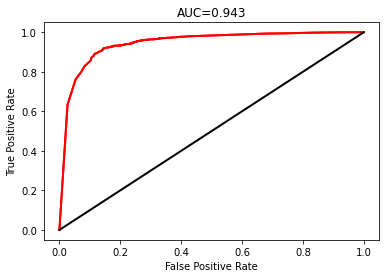

In [30]:
plot_auc(test_df['label'],test_df['predict'])

In [32]:
fpr, tpr, thresholds = roc_curve(test_df['label'], test_df['predict'])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.988472, G-Mean=0.888
